In [1]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch
import numpy as np
import pandas as pd
import pickle
from fair_loss import FairLoss
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader
from torchmetrics.classification import BinaryFairness
from fairlearn.metrics import demographic_parity_ratio,  demographic_parity_difference
import matplotlib.pyplot as plt

from sklearn.metrics import f1_score, balanced_accuracy_score,recall_score, confusion_matrix

# from datasets import ADULT, German, Lawschool, HealthHeritage
# from defenses import dp_defense

In [2]:
if torch.cuda.is_available():
    print("CUDA is available.")
else:
    # CUDA is not available
    print("CUDA is not available. Running on CPU.")

CUDA is available.


In [3]:
class LinReLU(nn.Module):

    """
    A linear layer followed by a ReLU activation layer.
    """    
    
    def __init__(self, in_size, out_size):
        super(LinReLU, self).__init__()      
        linear = nn.Linear(in_size, out_size)
        ReLU = nn.ReLU()
        # self.Dropout = nn.Dropout(0.25)
        self.layers = nn.Sequential(linear, ReLU)

    def reset_parameters(self):
        self.layers[0].reset_parameters()
        return self

    def forward(self, x):
        x = self.layers(x)
        return x

class FullyConnected(nn.Module):
    """
    A simple fully connected neural network with ReLU activations.
    """
    def __init__(self, input_size, layout):

        super(FullyConnected, self).__init__()
        layers = [nn.Flatten()]  # does not play any role, but makes the code neater
        prev_fc_size = input_size
        for i, fc_size in enumerate(layout):
            if i + 1 < len(layout):
                layers += [LinReLU(prev_fc_size, fc_size)]
            else:
                layers += [nn.Linear(prev_fc_size, 1), nn.Sigmoid()]
                # layers += [nn.Linear(prev_fc_size, fc_size)]
            prev_fc_size = fc_size
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        x = self.layers(x)
        return x

# Testing on SubGroup
1. BM
2. BW
3. WM
4. WW

- I am using .pkl for testing (WW_test.. and other files have less data)

In [4]:
client_data_dir='50_clients_data/client_subG_processed/'

state_codes=["WW","WM","BM","BW"]
for state_code in state_codes:
    print(state_code)

    with open(client_data_dir + f'{state_code}.pkl', 'rb') as f:
        test_data = pickle.load(f)

    total_length = sum(len(batch[0]) for batch in test_data)
    print(f'Total length of {state_code} test data: {total_length}')

WW
Total length of WW test data: 4437
WM
Total length of WM test data: 4673
BM
Total length of BM test data: 680
BW
Total length of BW test data: 784


In [17]:
def get_prob(y_pred, y_ori):
    matches_0 = 0
    matches_1 = 0
    total_zeros = 0
    total_ones = 0
    
    for pred, ori in zip(y_pred, y_ori):
        if ori == 0:  # Count for label 0
            total_zeros += 1
            if pred == ori:
                matches_0 += 1
        elif ori == 1:  # Count for label 1
            total_ones += 1
            if pred == ori:
                matches_1 += 1
    
    # Avoid division by zero
    prob_0 = matches_0 / total_zeros if total_zeros != 0 else 0
    prob_1 = matches_1 / total_ones if total_ones != 0 else 0
    
    return [prob_0, prob_1]


In [18]:
def divide_dict_values(sub_dict):
    results = {}
    for key1, value1 in sub_dict.items():
        for key2, value2 in sub_dict.items():
            if key1 != key2:
                try:
                    result = [v1 / v2 if v2 != 0 else float('nan') for v1, v2 in zip(value1, value2)]
                    results[f'{key1}/{key2}'] = result
                    # print(f'{key1}/{key2} = {result}')
                except ZeroDivisionError:
                    print(f'{key1}/{key2} = Division by zero error')
        print("====================")
    return results

In [28]:

def plot_results(exp_name="fair",model_name="CA",results={}):
    ratios = list(results.keys())
    label0_values = [result[0] for result in results.values()]
    label1_values = [result[1] for result in results.values()]

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

    x = np.arange(len(ratios))
    
    # Plot for Label 0
    ax1.bar(x, label0_values, width=0.6, color='skyblue', alpha=0.8)
    ax1.set_ylabel('Values')
    ax1.set_title('Label 0')
    ax1.set_xticks(x)
    ax1.set_xticklabels(ratios, rotation=45, ha='right')
    ax1.axhline(y=1, color='r', linestyle='--', alpha=0.5)

    # Plot for Label 1
    ax2.bar(x, label1_values, width=0.6, color='lightgreen', alpha=0.8)
    ax2.set_ylabel('Values')
    ax2.set_title('Label 1')
    ax2.set_xticks(x)
    ax2.set_xticklabels(ratios, rotation=45, ha='right')
    ax2.axhline(y=1, color='r', linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.savefig(f"graphs/{exp_name}/{model_name}.png", dpi=300, bbox_inches='tight')
    plt.show()


val_epoch_loss: 0.582497265270288   val_accuracy: 0.7031778228532792   TPR: 0.6752105455876968
val_epoch_loss: 0.6301734848898284   val_accuracy: 0.7331478707468436   TPR: 0.7806306306306307
val_epoch_loss: 0.558429010889747   val_accuracy: 0.7338235294117647   TPR: 0.7253218884120172
val_epoch_loss: 0.5538343119621277   val_accuracy: 0.735969387755102   TPR: 0.7119266055045872
CA is done


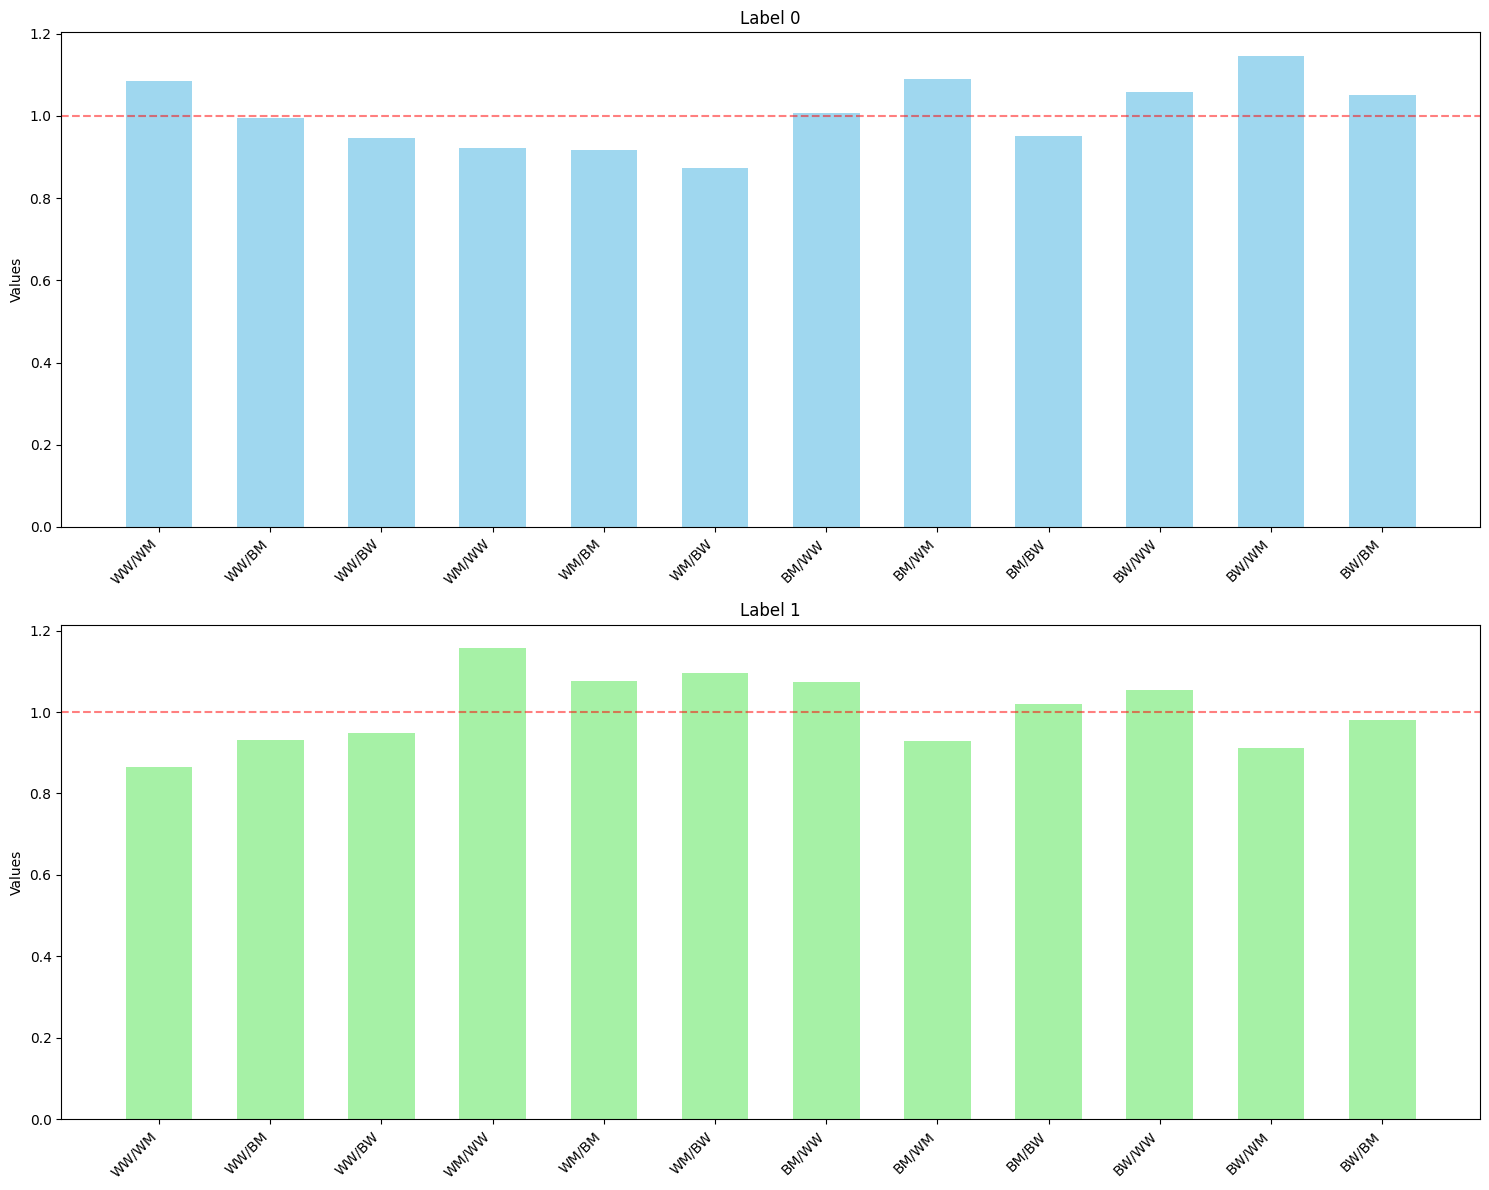

val_epoch_loss: 0.596344690528705   val_accuracy: 0.7065584854631508   TPR: 0.8919809593555474
val_epoch_loss: 0.6818557412040477   val_accuracy: 0.6486197303659319   TPR: 0.9310810810810811
val_epoch_loss: 0.5541272325949236   val_accuracy: 0.7382352941176471   TPR: 0.9291845493562232
val_epoch_loss: 0.5487847220897675   val_accuracy: 0.7512755102040817   TPR: 0.9376146788990826
FL is done


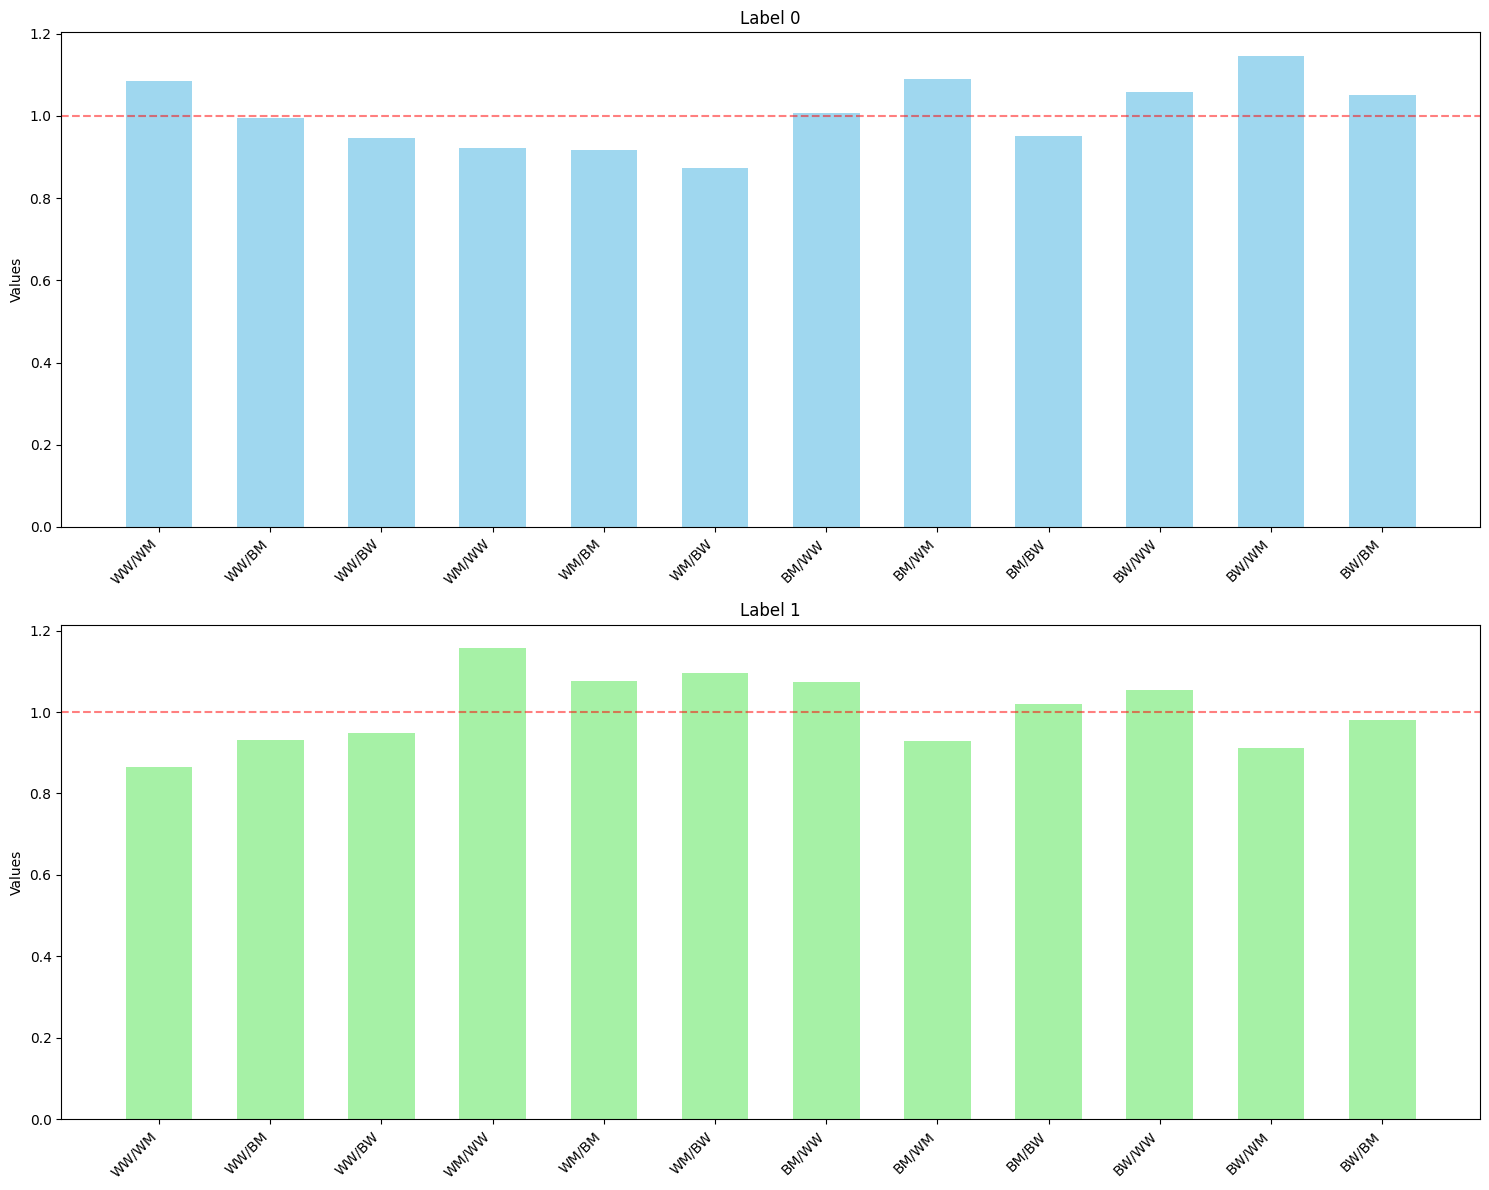

val_epoch_loss: 0.5851237394398064   val_accuracy: 0.7227856659905342   TPR: 0.8143537165873307
val_epoch_loss: 0.6565847080581042   val_accuracy: 0.7025465439760326   TPR: 0.8824324324324324
val_epoch_loss: 0.5536418286236849   val_accuracy: 0.7426470588235294   TPR: 0.8390557939914163
val_epoch_loss: 0.5456980443000794   val_accuracy: 0.7831632653061225   TPR: 0.8642201834862385
GA is done


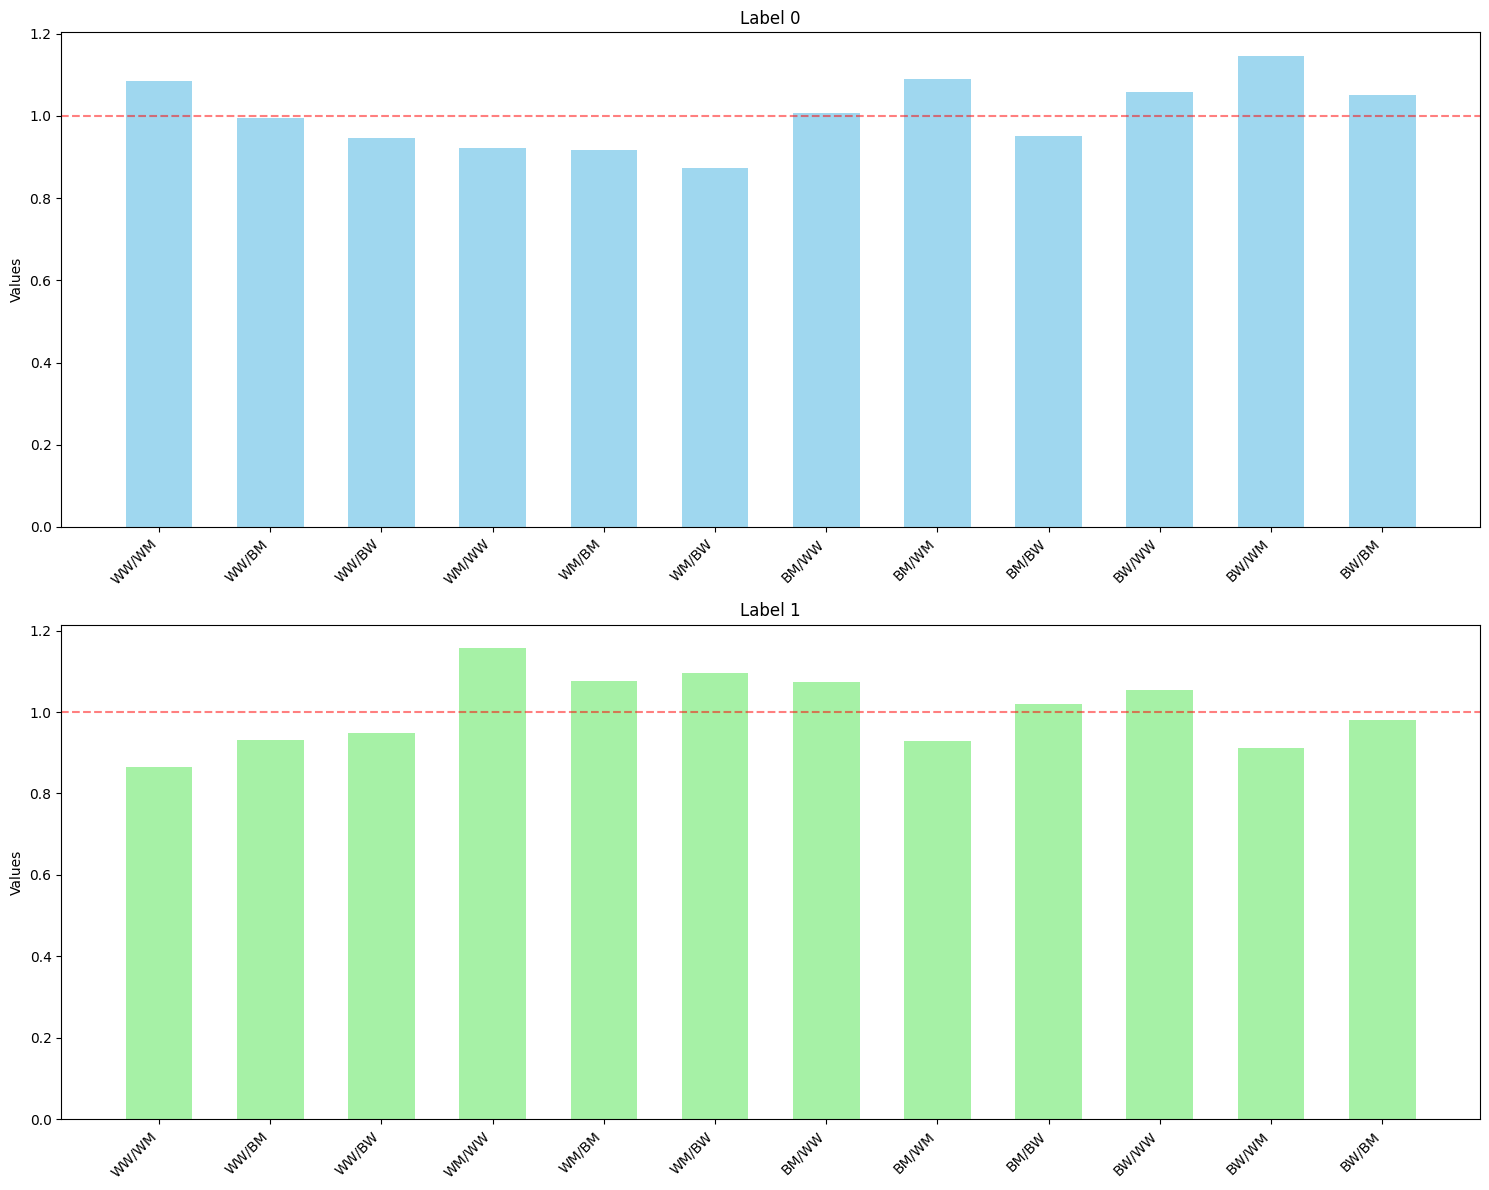

val_epoch_loss: 0.5843591996662908   val_accuracy: 0.7049808429118773   TPR: 0.6832662028560966
val_epoch_loss: 0.631129149170149   val_accuracy: 0.7303659319494971   TPR: 0.7833333333333333
val_epoch_loss: 0.5611736300316724   val_accuracy: 0.7382352941176471   TPR: 0.7274678111587983
val_epoch_loss: 0.5562842667102814   val_accuracy: 0.7334183673469388   TPR: 0.7119266055045872
IL is done


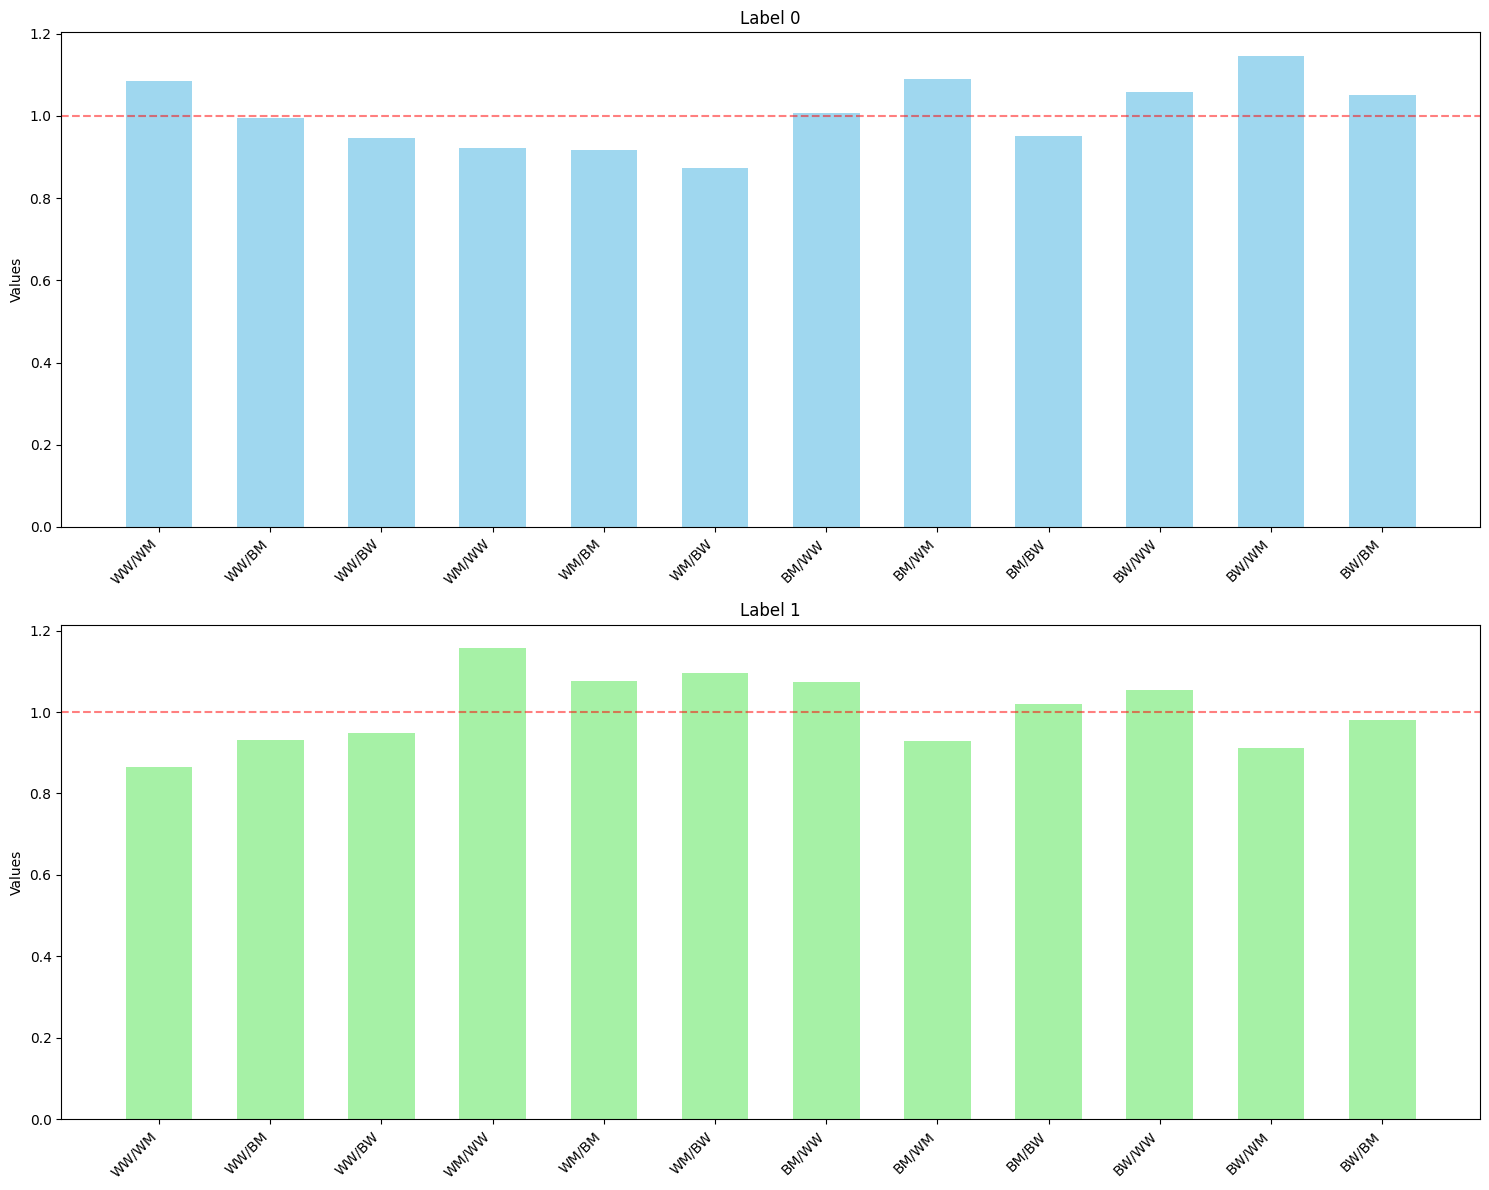

val_epoch_loss: 0.5907189393643852   val_accuracy: 0.723912553527158   TPR: 0.863786158916148
val_epoch_loss: 0.6689413560896503   val_accuracy: 0.6811470147656752   TPR: 0.9117117117117117
val_epoch_loss: 0.5476262908090245   val_accuracy: 0.75   TPR: 0.8905579399141631
val_epoch_loss: 0.545712045431137   val_accuracy: 0.7653061224489796   TPR: 0.908256880733945
OH is done


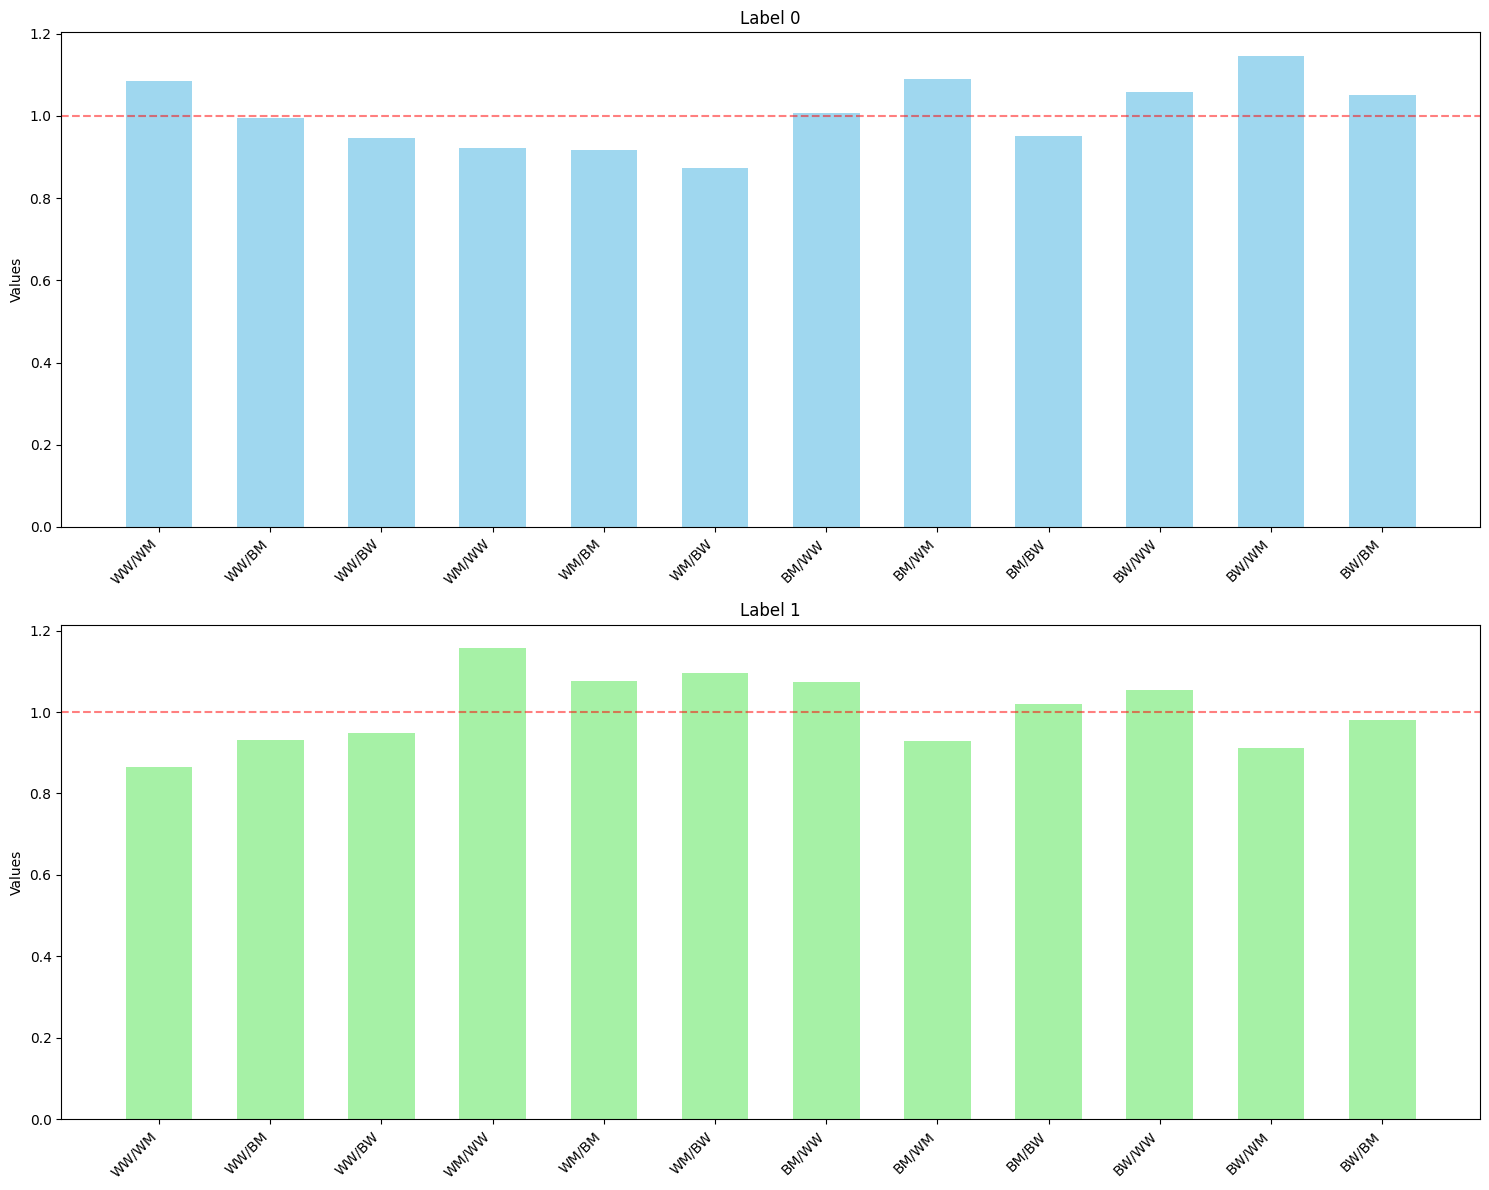

val_epoch_loss: 0.587478456522921   val_accuracy: 0.7259409510930809   TPR: 0.7949469058952765
val_epoch_loss: 0.6580442960570458   val_accuracy: 0.706826449818104   TPR: 0.8675675675675676
val_epoch_loss: 0.5574734468351711   val_accuracy: 0.7411764705882353   TPR: 0.8304721030042919
val_epoch_loss: 0.5495282006263733   val_accuracy: 0.7716836734693877   TPR: 0.8440366972477065
PA is done


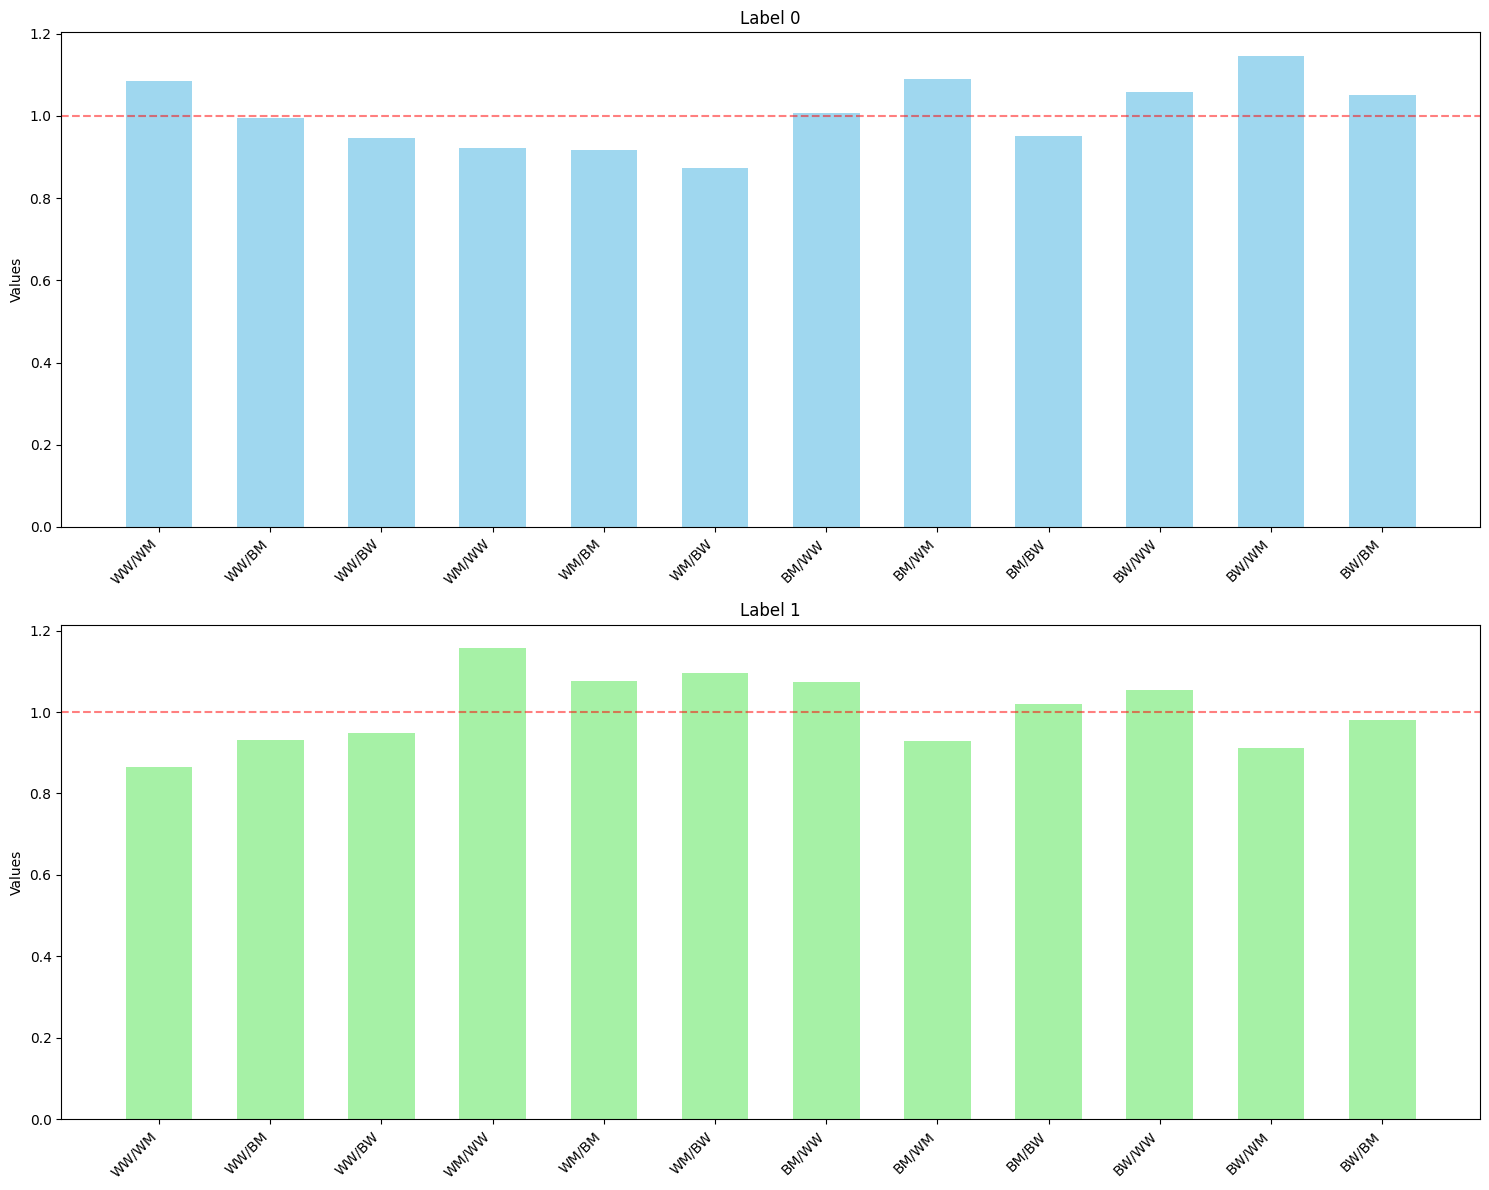

val_epoch_loss: 0.587574934359077   val_accuracy: 0.7248140635564571   TPR: 0.7861589161479312
val_epoch_loss: 0.6521860825366714   val_accuracy: 0.7093943933233469   TPR: 0.859009009009009
val_epoch_loss: 0.56247778236866   val_accuracy: 0.75   TPR: 0.8304721030042919
val_epoch_loss: 0.5513527274131775   val_accuracy: 0.7589285714285714   TPR: 0.8201834862385321
TX is done


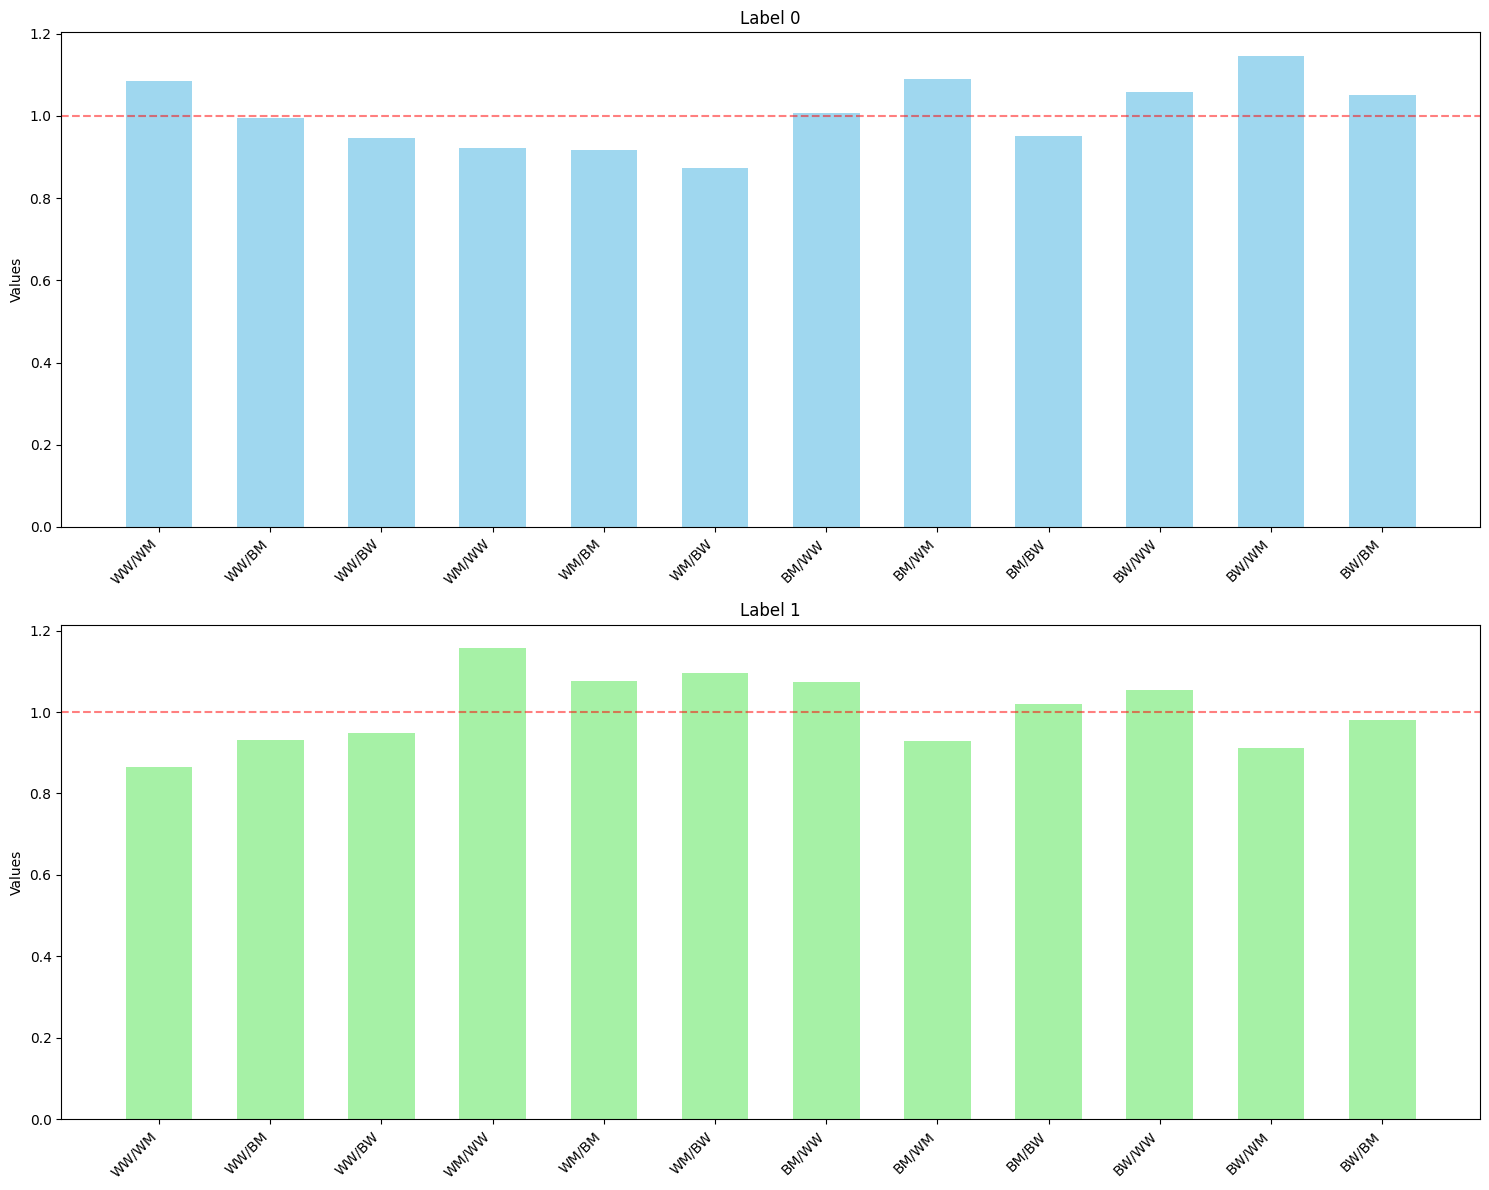

In [32]:
four_client_result_ori=[]
four_client_result_pred=[]
four_client_result_TPR={}
four_client_result_cm={}

layout = [100, 100, 2]
batch_size = 32
num_epochs = 5  
input_dim = 10

model = FullyConnected(input_dim, layout)
criterion = nn.BCELoss() 
optimizer = optim.Adam(model.parameters(), lr=0.01) 


# model_name="CA"
model_name=[ "CA","FL","GA","IL","OH","PA","TX"]
exp_name="fair" # name as per folder name

for name in model_name:
    # model.load_state_dict(torch.load(f'50_clients_data/clients_trained_model/{name}.pth'))
    # model.load_state_dict(torch.load(f'50_clients_data/client_DP_trained_model/{name}.pth'))
    model.load_state_dict(torch.load(f'50_clients_data/clients_fair_trained_model/{name}.pth'))
    # model.load_state_dict(torch.load(f'50_clients_data/clients_DP_Fair_trained_model/{name}.pth'))

    
    for state_code in state_codes:

        with open(client_data_dir + f'{state_code}.pkl', 'rb') as f:
            test_data = pickle.load(f)

        # total_length = sum(len(batch[0]) for batch in test_data)
        # print(f'Total length of {state_code} test data: {total_length}')
        
        temp_out = []
        temp_lab = []
        temp_group = []
        all_actaul_y=[]
        all_pred_y=[]
        temp_list_act=[]
        temp_list_pred=[]
        all_labels = []
        all_predicted_classes = []
        size_of_data=[]
        raw_out=[]

        model.eval()
        with torch.no_grad():
            val_running_loss = 0.0
            val_correct = 0
            val_total = 0        

            for i, (inputs, labels) in enumerate(test_data):
                # if i >= 50: #50*32 =1600 points:
                #     print(i)
                #     break
                
                labels = labels.unsqueeze(1).float()
                temp_lab.append(labels)
                outputs = model(inputs)
                
                val_loss = criterion(outputs, labels)
                val_running_loss += val_loss.item()

                raw_out.append(outputs)
                
                predicted_classes = (outputs > 0.6).float()
                
                temp_out.append(predicted_classes)

                val_correct += (predicted_classes == labels).sum().item()
                val_total += labels.size(0)

                all_labels.extend(labels.cpu().numpy())
                all_predicted_classes.extend(predicted_classes.cpu().numpy())

            val_epoch_loss = val_running_loss / len(test_data)
            val_accuracy = val_correct / val_total

            tpr = recall_score(all_labels, all_predicted_classes)
            f1 = f1_score(all_labels, all_predicted_classes)
            cm = confusion_matrix(all_labels, all_predicted_classes)

            all_labels = np.array(all_labels)
            # print(f"Total length of {state_code} :", len(all_labels))
            all_predicted_classes = np.array(all_predicted_classes)

            four_client_result_ori.append(all_labels)
            four_client_result_pred.append(all_predicted_classes)
            four_client_result_TPR[state_code] = tpr
            four_client_result_cm[state_code] = cm
            
            print("val_epoch_loss:",val_epoch_loss, "  val_accuracy:", val_accuracy, "  TPR:", tpr)

        # print(cm)

    WW_pred=four_client_result_pred[0].flatten().tolist()
    WM_pred=four_client_result_pred[1].flatten().tolist()
    BM_pred=four_client_result_pred[2].flatten().tolist()
    BW_pred=four_client_result_pred[3].flatten().tolist()

    WW_ori=four_client_result_ori[0].flatten().tolist()
    WM_ori=four_client_result_ori[1].flatten().tolist()
    BM_ori=four_client_result_ori[2].flatten().tolist()
    BW_ori=four_client_result_ori[3].flatten().tolist()

    all_subG_pred=[WW_pred,WM_pred,BM_pred,BW_pred]
    all_subG_ori=[WW_ori,WM_ori,BM_ori,BW_ori]
    prob_all_sub=[]
    sub_dict={"WW":0,"WM":0,"BM":0,"BW":0}
    for idx, sgrp in enumerate(sub_dict.keys()):
        prob = get_prob(all_subG_pred[idx], all_subG_ori[idx])
        sub_dict[sgrp] = prob

    result_a=divide_dict_values(sub_dict)
    
    print(f"{name} is done")

    a=plot_results(exp_name,name,result_a)

    
    


In [30]:
# temp_lab[0],raw_out[0],temp_out[0]

In [22]:
four_client_result_cm

# [[TP, FP],  
#  [FN, TN]]

{'WW': array([[1058,  648],
        [ 633, 2098]]),
 'WM': array([[1407, 1046],
        [ 336, 1884]]),
 'BM': array([[120,  94],
        [ 82, 384]]),
 'BW': array([[142,  97],
        [ 93, 452]])}

In [11]:
# WW_pred=four_client_result_pred[0].flatten().tolist()
# WM_pred=four_client_result_pred[1].flatten().tolist()
# BM_pred=four_client_result_pred[2].flatten().tolist()
# BW_pred=four_client_result_pred[3].flatten().tolist()

# WW_ori=four_client_result_ori[0].flatten().tolist()
# WM_ori=four_client_result_ori[1].flatten().tolist()
# BM_ori=four_client_result_ori[2].flatten().tolist()
# BW_ori=four_client_result_ori[3].flatten().tolist()

In [12]:
# def get_prob(y_pred, y_ori):
#     matches_0 = 0
#     matches_1 = 0
#     total_zeros = 0
#     total_ones = 0
    
#     for pred, ori in zip(y_pred, y_ori):
#         if ori == 0:  # Count for label 0
#             total_zeros += 1
#             if pred == ori:
#                 matches_0 += 1
#         elif ori == 1:  # Count for label 1
#             total_ones += 1
#             if pred == ori:
#                 matches_1 += 1
    
#     # Avoid division by zero
#     prob_0 = matches_0 / total_zeros if total_zeros != 0 else 0
#     prob_1 = matches_1 / total_ones if total_ones != 0 else 0
    
#     return [prob_0, prob_1]


In [13]:
# all_subG_pred=[WW_pred,WM_pred,BM_pred,BW_pred]
# all_subG_ori=[WW_ori,WM_ori,BM_ori,BW_ori]
# prob_all_sub=[]
# sub_dict={"WW":0,"WM":0,"BM":0,"BW":0}
# for idx, sgrp in enumerate(sub_dict.keys()):
#     prob = get_prob(all_subG_pred[idx], all_subG_ori[idx])
#     sub_dict[sgrp] = prob


sub_dict

{'WW': [0.8640093786635404, 0.5225192237275723],
 'WM': [0.8214431308601712, 0.6549549549549549],
 'BM': [0.8738317757009346, 0.5407725321888412],
 'BW': [0.899581589958159, 0.5045871559633027]}

In [14]:
# def divide_dict_values(sub_dict):
#     results = {}
#     for key1, value1 in sub_dict.items():
#         for key2, value2 in sub_dict.items():
#             if key1 != key2:
#                 try:
#                     result = [v1 / v2 if v2 != 0 else float('nan') for v1, v2 in zip(value1, value2)]
#                     results[f'{key1}/{key2}'] = result
#                     print(f'{key1}/{key2} = {result}')
#                 except ZeroDivisionError:
#                     print(f'{key1}/{key2} = Division by zero error')
#         print("====================")
#     return results

In [15]:


# def plot_results(model_name,results):
#     ratios = list(results.keys())
#     label0_values = [result[0] for result in results.values()]
#     label1_values = [result[1] for result in results.values()]

#     fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

#     x = np.arange(len(ratios))
    
#     # Plot for Label 0
#     ax1.bar(x, label0_values, width=0.6, color='skyblue', alpha=0.8)
#     ax1.set_ylabel('Values')
#     ax1.set_title('Label 0')
#     ax1.set_xticks(x)
#     ax1.set_xticklabels(ratios, rotation=45, ha='right')
#     ax1.axhline(y=1, color='r', linestyle='--', alpha=0.5)

#     # Plot for Label 1
#     ax2.bar(x, label1_values, width=0.6, color='lightgreen', alpha=0.8)
#     ax2.set_ylabel('Values')
#     ax2.set_title('Label 1')
#     ax2.set_xticks(x)
#     ax2.set_xticklabels(ratios, rotation=45, ha='right')
#     ax2.axhline(y=1, color='r', linestyle='--', alpha=0.5)

#     plt.tight_layout()
#     plt.savefig(f"graphs/{model_name}.png", dpi=300, bbox_inches='tight')
#     plt.show()




In [16]:
# result_a=divide_dict_values(sub_dict)

# plot_results(model_name,result_a)

In [17]:
# def divide_dict_values(sub_dict):
#     # Iterate over each key-value pair in the dictionary
#     for key1, value1 in sub_dict.items():
#         for key2, value2 in sub_dict.items():
#             if key1 != key2:  # Ensure we don't divide a value by itself
#                 try:
#                     # Perform element-wise division for the lists
#                     result = [v1 / v2 if v2 != 0 else 'Division by zero error' for v1, v2 in zip(value1, value2)]
#                     print(f'{key1}/{key2} = {result}')
#                 except ZeroDivisionError:
#                     print(f'{key1}/{key2} = Division by zero error')
#         print("====================")
# print("Left side label:0 , Right side label:1 \n")
# divide_dict_values(sub_dict)
